In [1]:
import math
from functools import partial, reduce
from operator import mul
from warnings import simplefilter

import numpy as np
from jax import Array


simplefilter(action="ignore", category=FutureWarning)

from test.helpers import (
    get_mlp_sde,
    SDE,
    simple_batch_sde_solve,
)

import diffrax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    SaveAt,
    SpaceTimeTimeLevyArea,
)


jax.config.update("jax_enable_x64", True)


@partial(jax.jit, static_argnames=("max_len",))
def energy_distance(x: Array, y: Array, max_len: int = 2**16):
    assert y.ndim == x.ndim
    assert x.shape[1:] == y.shape[1:]
    prod = reduce(mul, x.shape[1:], 1)
    if prod >= 4:
        max_len = int(max_len / math.sqrt(prod))

    if x.shape[0] > max_len:
        x = x[:max_len]
    if y.shape[0] > max_len:
        y = y[:max_len]

    @partial(jax.vmap, in_axes=(None, 0))
    def _dist_single(_x, _y_single):
        assert _x.ndim == _y_single.ndim + 1, f"{_x.ndim} != {_y_single.ndim + 1}"
        diff = _x - _y_single
        if x.ndim > 1:
            # take the norm over all axes except the first one
            diff = jnp.sqrt(jnp.sum(diff**2, axis=tuple(range(1, diff.ndim))))
        return jnp.mean(jnp.abs(diff))

    def dist(_x, _y):
        assert _x.ndim == _y.ndim
        return jnp.mean(_dist_single(_x, _y))

    return 2 * dist(x, y) - dist(x, x) - dist(y, y)


def draw_order(results_dict):
    fig, ax = plt.subplots()
    fig.set_dpi(100)

    orders = "Orders:\n"
    scats = []
    for i, (name, result) in enumerate(results_dict.items()):
        steps, errs, slice = result
        steps = steps[slice]
        errs = errs[slice]
        trend = np.polyfit(-np.log(steps), np.log(errs), 1)
        order, _ = trend
        # plot the trend line
        # trend_f = np.poly1d(trend)
        # ax.plot(steps, np.exp(trend_f(-np.log(steps))), linewidth=1.0)

        # plot the points
        scat = ax.scatter(
            steps,
            errs,
            label=f"{name}: {order:.2f}",
        )
        scats.append(scat)

        orders += f"{name}: {order:.2f}\n"
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("RMS error")
    ax.set_xlabel("Average number of vector field evaluations")
    ax.legend(fancybox=True, fontsize="large")
    plt.show()


t0 = 0.0
t1 = 4.0
saveat = SaveAt(t1=True)
constant_controller = diffrax.ConstantStepSize()
mlp_sde: SDE = get_mlp_sde(t0, t1, jnp.float64, jr.key(0), 5, y_dim=4)

num_samples = 100000
keys = jr.split(jr.key(0), num_samples)

In [2]:
# ref_sols, ref_steps = simple_batch_sde_solve(
#     keys,
#     mlp_sde,
#     Euler(),
#     SpaceTimeTimeLevyArea,
#     2**-14,
#     constant_controller,
#     0,
#     saveat,
#     use_progress_meter=True,
#     use_vbt=False,
# )
# jnp.save("data/ref_sol_mlp_100k.npy", ref_sols)
ref_sols = jnp.load("data/ref_sol_mlp_100k.npy")

In [3]:
def evaluate_solve(solver, dt, controller):
    sols, steps = simple_batch_sde_solve(
        keys,
        mlp_sde,
        solver,
        SpaceTimeTimeLevyArea,
        dt,
        controller,
        0,
        saveat,
        use_progress_meter=True,
        use_vbt=False,
    )

    errors = energy_distance(ref_sols, sols)
    return errors, jnp.mean(steps)

In [4]:
dts = [0.5**i for i in range(0, 9)]
# errors_euler = []
# steps_euler = []
#
# for dt in dts:
#     print(f"dt = {dt}")
#     errors_, steps_ = evaluate_solve(Euler(), dt, constant_controller)
#     errors_euler.append(errors_)
#     steps_euler.append(steps_)
#
# errors_euler = jnp.array(errors_euler)
# steps_euler = jnp.array(steps_euler)
# with open("data/errors_euler.npy", "wb") as f:
#     jnp.save(f, errors_euler)
#     jnp.save(f, steps_euler)

with open("data/errors_euler.npy", "rb") as f:
    errors_euler = jnp.load(f)
    steps_euler = jnp.load(f)

In [5]:
ctols = [0.5**i for i in range(-7, 3)]
# errors_talay_adaptive = []
# steps_talay_adaptive = []
#
# for ctol in ctols:
#     solver = Talay(jr.key(7), error_mult=ctol, use_levy_area=True)
#     controller = TalayController(ctol, dtmin=2**-10, dtmax=4.0)
#     print(f"ctol = {ctol}")
#     errors_, steps_ = evaluate_solve(solver, 1.0, controller)
#     errors_talay_adaptive.append(errors_)
#     steps_talay_adaptive.append(steps_)
#
# errors_talay_adaptive = jnp.array(errors_talay_adaptive)
# steps_talay_adaptive = jnp.array(steps_talay_adaptive)
# with open("data/errors_talay_adaptive.npy", "wb") as f:
#     jnp.save(f, errors_talay_adaptive)
#     jnp.save(f, steps_talay_adaptive)

with open("data/errors_talay_adaptive.npy", "rb") as f:
    errors_talay_adaptive = jnp.load(f)
    steps_talay_adaptive = jnp.load(f)

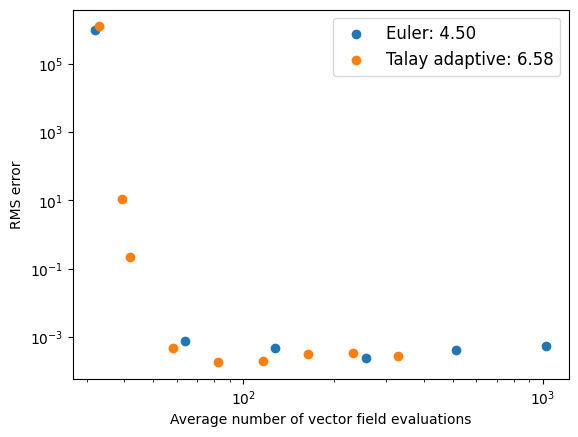

In [7]:
draw_order(
    {
        "Euler": (steps_euler, errors_euler, slice(3, None)),
        "Talay adaptive": (steps_talay_adaptive, errors_talay_adaptive, slice(1, None)),
    }
)